## PRACTICA ACO
El algoritmo de optimización por colonia de hormigas (ACO por sus siglas en inglés) no
solo puedes implementarse para problemas combinatorios, también puede
determinar extremos de funciones analíticas. En esta práctica se explora su
implementación como estrategia para determinar el valor mínimo de una función
univariable.

In [1]:
# Impor
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

In [2]:
# Parametros inciales
NUM_HORMIGAS = 100
NUM_ITERACIONES = 100
NUM_PUNTOS = 200
MIN = 0
MAX = 10
TASA_EVAPORACION = 0.5
Q = 1.0 # Es la cantidad de feromona depositada por una hormiga
ALFA = 1.0 # IMPORTANCIA DE LA FEROMONA
BETA = 3.0 # IMPORTANCIA DE LA VISIBILIDAD
X = np.linspace(MIN, MAX, NUM_PUNTOS)

In [3]:
# Función objetivo
def fun_obj(x):
    return x * np.sin(4 * x) + 1.1 * x * np.sin(2 * x)      



In [4]:
feromonas = np.ones(NUM_PUNTOS) * 0.1 # Inicialización de feromonas

# Heurística de visibilidad, inversamente proporcional al valor de la función objetivo
def calcular_visibilidad():
    valor_f = np.array([fun_obj(x) for x in np.linspace(MIN, MAX, NUM_PUNTOS)])
    visibilidad = 1 / (1 + valor_f)  # Evitar división por cero
    return visibilidad
visibilidad = calcular_visibilidad()

In [5]:
# Funciones principales del algoritmo
def calcular_probabilidades(feromonas, visibilidad):
    # Calcular las probabilidades de selección de cada punto
    numerador = (feromonas ** ALFA) * (visibilidad ** BETA)
    total = np.sum(numerador)
    if total == 0:
        total = 1e-10  # Evitar división por cero
    return numerador / total

def seleccionar_puntos(probabilidades):
    # Seleccionar puntos basados en las probabilidades calculadas
    r = random.random()
    acumulado = 0.0
    for i, prob in enumerate(probabilidades):
        acumulado += prob
        if r <= acumulado:
            return i
    return len(probabilidades) - 1

def actualizar_feromonas(feromonas, soluciones):
    # Evaporar feromonas
    feromonas *= (1 - TASA_EVAPORACION)
    # Reforzar feromonas en los puntos seleccionados
    for x_val, fx in soluciones:
        idx = np.argmin(np.abs(X - x_val))
        feromonas[idx] += Q / (abs(fx) + 1)  # Evitar división por cero
    return feromonas

In [6]:
def ACO_minimizacion():
    mejor_x = None
    mejor_f = float('inf')
    #global feromonas, visibilidad # Sirve para modificar las variables globales
    feromonas = np.ones(NUM_PUNTOS) * 0.1
    visibilidad = calcular_visibilidad()
        # 存储历史数据用于可视化
    visualizar=True
    historial_feromonas = []
    historial_mejores = []
    historial_soluciones = []

    for iteracion in range(NUM_ITERACIONES):
        soluciones = []
        
        for _ in range(NUM_HORMIGAS):
            # Calcular probabilidades para cada punto
            probabilidades = calcular_probabilidades(feromonas, visibilidad) 
            idx = seleccionar_puntos(probabilidades)    # Selección del punto
            x_val = X[idx]                              # Obtener el valor de x
            fx = fun_obj(x_val)                         # Evaluar la función objetivo
            soluciones.append((x_val, fx))              # Almacenar la solución
            if fx < mejor_f:                            # Actualizar el mejor resultado encontrado
                mejor_f = fx
                mejor_x = x_val
                mejor_iter = iteracion
        # Actualizar feromonas
        feromonas = actualizar_feromonas(feromonas, soluciones)
         # 存储历史数据
        if visualizar:
            historial_feromonas.append(feromonas.copy())
            historial_mejores.append((mejor_x, mejor_f))
            historial_soluciones.append(soluciones.copy())


    print(50 * "=")
    print("\nMejor solución encontrada:")
    print(f"x: {mejor_x}, f(x): {mejor_f}, Iteración: {mejor_iter}")
    print("\nFIN DEL ALGORITMO ACO\n")
    print(50 * "=")

    if visualizar:
        visualizar_resultados(historial_feromonas, historial_mejores, historial_soluciones)

    return mejor_x, mejor_f, mejor_iter

In [7]:
# 可视化函数
def visualizar_resultados(historial_feromonas, historial_mejores, historial_soluciones):
    # 创建图形和子图
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Algoritmo de Colonias de Hormigas (ACO) para Minimización', fontsize=16, fontweight='bold')
    
    # 1. 目标函数和最优解
    x_vals = np.linspace(MIN, MAX, 1000)
    y_vals = fun_obj(x_vals)
    axs[0, 0].plot(x_vals, y_vals, 'b-', linewidth=2, label='f(x) = (x-3)² + sin(5x)')
    
    # 标记最优解
    mejor_x, mejor_f = historial_mejores[-1]
    axs[0, 0].plot(mejor_x, mejor_f, 'ro', markersize=10, label=f'Mínimo: x={mejor_x:.3f}, f(x)={mejor_f:.3f}')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('f(x)')
    axs[0, 0].set_title('Función Objetivo y Solución Óptima')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    
    # 2. 信息素分布演化
    iteraciones = len(historial_feromonas)
    for i in range(0, iteraciones, max(1, iteraciones//5)):
        axs[0, 1].plot(X, historial_feromonas[i], 
                      label=f'Iteración {i}', alpha=0.7)
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('Nivel de Feromonas')
    axs[0, 1].set_title('Evolución de la Distribución de Feromonas')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. 收敛历史
    iteraciones = range(len(historial_mejores))
    mejores_valores = [mejor_f for _, mejor_f in historial_mejores]
    axs[1, 0].plot(iteraciones, mejores_valores, 'g-', linewidth=2)
    axs[1, 0].set_xlabel('Iteración')
    axs[1, 0].set_ylabel('Mejor f(x)')
    axs[1, 0].set_title('Convergencia del Algoritmo')
    axs[1, 0].grid(True, alpha=0.3)
    
    # 4. 解的分布（最后一次迭代）
    ultimas_soluciones = historial_soluciones[-1]
    x_sol = [sol[0] for sol in ultimas_soluciones]
    y_sol = [sol[1] for sol in ultimas_soluciones]
    
    axs[1, 1].scatter(x_sol, y_sol, c='red', alpha=0.6, s=50, label='Soluciones de hormigas')
    axs[1, 1].plot(x_vals, y_vals, 'b-', linewidth=1, alpha=0.7, label='Función objetivo')
    axs[1, 1].plot(mejor_x, mejor_f, 'go', markersize=8, label='Mejor solución')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('f(x)')
    axs[1, 1].set_title('Distribución de Soluciones (Última Iteración)')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    plt.show()
    
    # 创建动画展示收敛过程（可选）
    crear_animacion_convergencia(historial_mejores, historial_soluciones)

def crear_animacion_convergencia(historial_mejores, historial_soluciones):
    """创建收敛过程的动画"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_vals = np.linspace(MIN, MAX, 1000)
    y_vals = fun_obj(x_vals)
    
    def animar(frame):
        ax.clear()
        ax.plot(x_vals, y_vals, 'b-', linewidth=2, label='f(x)')
        
        # 绘制当前解
        soluciones_frame = historial_soluciones[frame]
        x_sol = [sol[0] for sol in soluciones_frame]
        y_sol = [sol[1] for sol in soluciones_frame]
        ax.scatter(x_sol, y_sol, c='red', alpha=0.6, s=30, label='Soluciones')
        
        # 标记当前最优解
        mejor_x, mejor_f = historial_mejores[frame]
        ax.plot(mejor_x, mejor_f, 'go', markersize=8, label='Mejor solución')
        
        ax.set_xlim(MIN, MAX)
        ax.set_ylim(min(y_vals)-0.5, max(y_vals)+0.5)
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title(f'Proceso de Optimización ACO - Iteración {frame}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 创建动画（每5帧采样一次以减少文件大小）
    anim = animation.FuncAnimation(fig, animar, frames=range(0, len(historial_mejores), 5), 
                                 interval=200, repeat=False)
    
    # 保存动画（需要安装ffmpeg）
    try:
        anim.save('ACO_convergencia.gif', writer='pillow', fps=5)
        print("Animación guardada como 'ACO_convergencia.gif'")
    except:
        print("No se pudo guardar la animación. Instala 'pillow' para guardar GIFs.")
    
    plt.close()

# 分析参数敏感性
def analizar_sensibilidad():
    """分析关键参数的敏感性"""
    parametros = {
        'NUM_HORMIGAS': [20, 50, 100],
        'TASA_EVAPORACION': [0.05, 0.15, 0.3],
        'BETA': [1.0, 2.0, 5.0]
    }
    
    resultados = []
    
    print("Análisis de Sensibilidad de Parámetros:")
    print("=" * 50)
    
    for param, valores in parametros.items():
        print(f"\nProbando {param}:")
        original_valor = globals()[param]
        
        for valor in valores:
            globals()[param] = valor
            _, mejor_f, _ = ACO_minimizacion(visualizar=False)
            resultados.append((param, valor, mejor_f))
            print(f"  {param}={valor}: f(x)={mejor_f:.4f}")
        
        # Restaurar valor original
        globals()[param] = original_valor
    
    return resultados


Mejor solución encontrada:
x: 4.3216080402010055, f(x): -0.972978722455383, Iteración: 0

FIN DEL ALGORITMO ACO



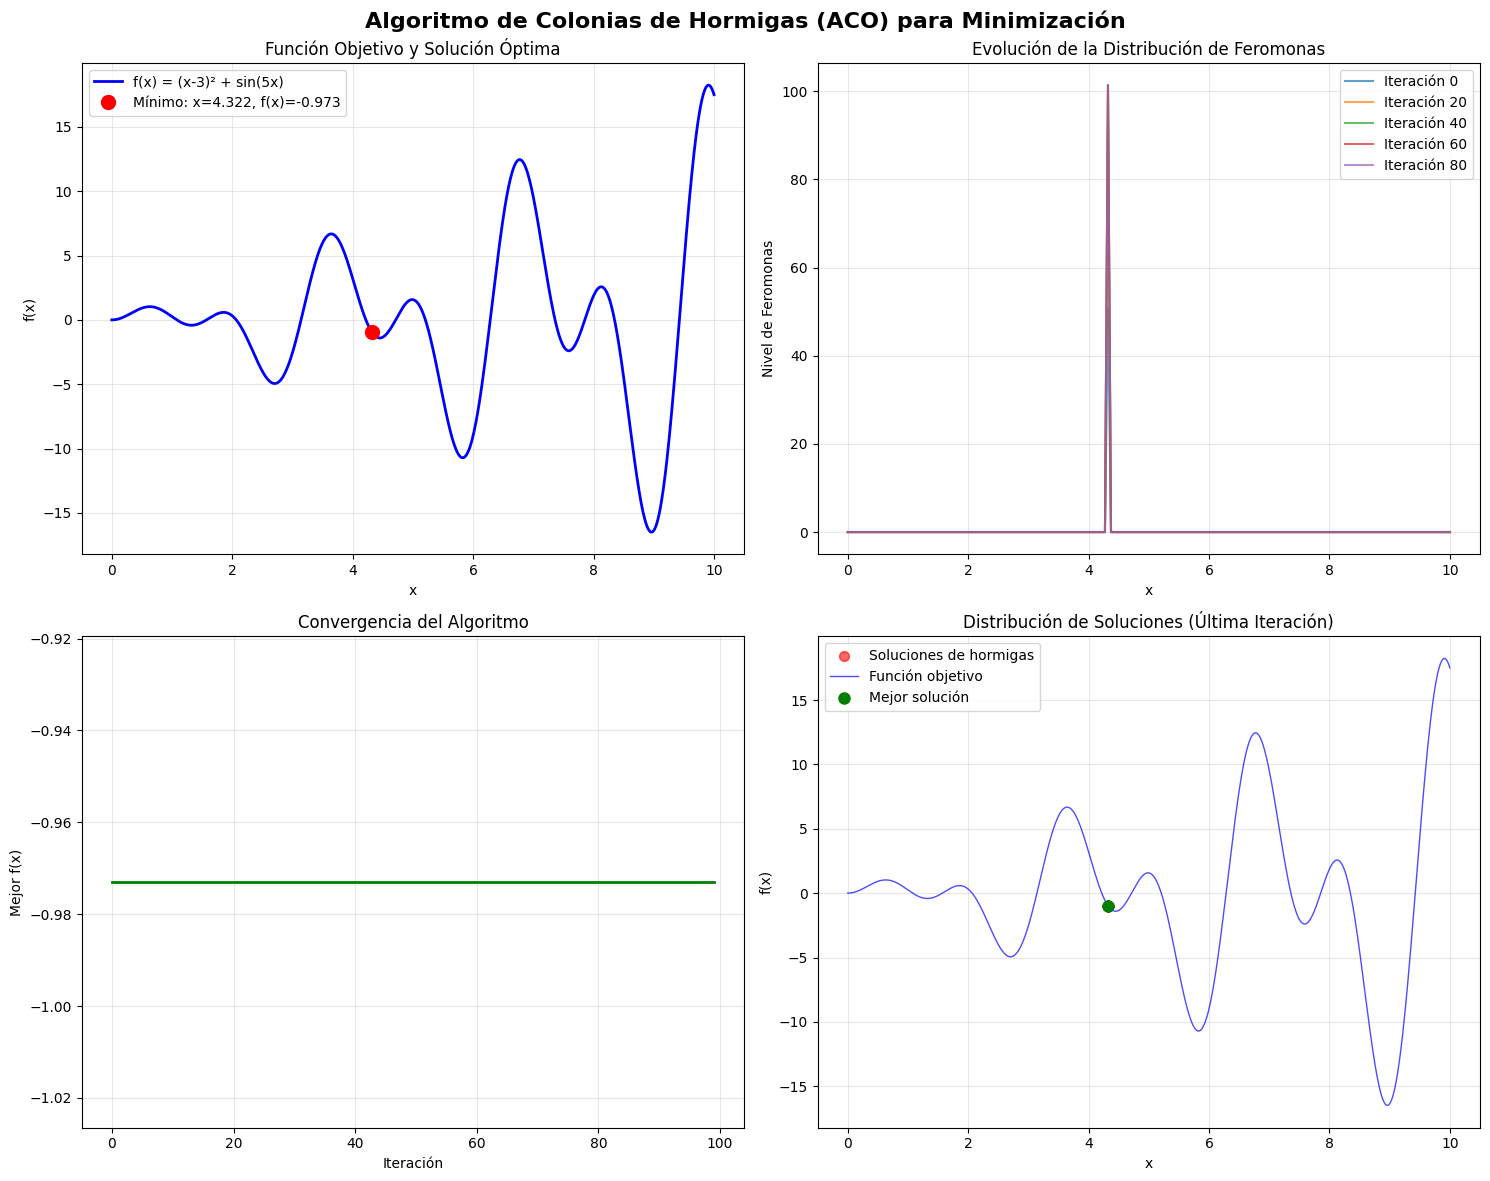

Animación guardada como 'ACO_convergencia.gif'


In [8]:
if __name__ == "__main__":
    mejor_x, mejor_f, mejor_iter = ACO_minimizacion()


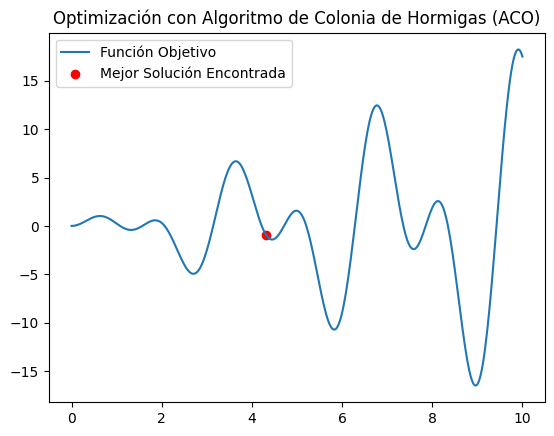

In [9]:
x = np.linspace(MIN, MAX, 400)
y = fun_obj(x)  
plt.plot(x, y, label='Función Objetivo')
plt.scatter(mejor_x, mejor_f, color='red', label='Mejor Solución Encontrada')
plt.title('Optimización con Algoritmo de Colonia de Hormigas (ACO)')
plt.legend()
plt.show()
